<a href="https://colab.research.google.com/github/garestrear/poligonal_clusterization/blob/master/Euclidean_kmeans_poligonal_clusterization_kmean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poligonal clusterization using kmeans with Euclidean Distance distance.
By Gustavo Restrepo. August 2020

# Explicación del código
Se realiza clusterización de la base de datos por el método kmeans. Se usa la distancia euclidea.

Sobre la poligonales de la Base de Datoos se sabe lo siguiente:

*   Poseen propiedades "deseables" para ser usadas en el ajuste de curvas, por ejemplo permiten la  instalación de una malla ortogonal sobre regiones "irregulares".
*   Presentan características similares (concavidad, longitud, distribución de puntos, simples,...)
*   Puntos aproximadamente equiespaciados (en la mayoría de los casos)
*   Los puntos se encentran almacenados en una matriz compleja $ 40000\times 15$

Algunas necesidas de clusterizar estas poligonales:

*   Se realizan procesos de comparación de segmentos de curva con las poligonales, ¡muchos!. Lo cual es costoso e ineficiente.
*   Detección de outliers en la base de datos de poligonales
*   Necesidad de conocer a fondo la base de datos de poligonales para implemntar mejoras.














##**Problem:**

We want to clusterizate a set of poligonal curves. All of this are standarized in such way that the first point is always (0,0) and the end point is (1,0). 

## **Principal Tools:**
### **1. kmeans**
K-Means is a very simple clustering algorithm (clustering belongs to unsupervised learning). Given a fixed number of clusters and an input dataset the algorithm tries to partition the data into clusters such that the clusters have high intra-class similarity and low inter-class similarity. Here we uses an easy and understandable implementation made for bantak (Git-Hub account of the code author).

#### Algorithm

1. Initialize the cluster centers, either randomly within the range of the input data or (recommended) with some of the existing training examples

2. Until convergence  

   2.1. Assign each datapoint to the closest cluster. The distance between a point and cluster center is measured using diferents distances.  

   2.2. Update the current estimates of the cluster centers by setting them to the mean of all instance belonging to that cluster  
   
   
#### Objective function

The underlying objective function tries to find cluster centers such that, if the data are partitioned into the corresponding clusters, distances between data points and their closest cluster centers become as small as possible.

Given a set of datapoints ${x_1, ..., x_n}$ and a positive number $k$, find the clusters $C_1, ..., C_k$ that minimize

\begin{equation}
J = \sum_{i=1}^n \, \sum_{j=1}^k \, z_{ij} \, || x_i - \mu_j ||_2
\end{equation}

where:  
- $z_{ij} \in \{0,1\}$ defines whether of not datapoint $x_i$ belongs to cluster $C_j$
- $\mu_j$ denotes the cluster center of cluster $C_j$
- $|| \, ||_2$ denotes the Euclidean distance

### Disadvantages of K-Means
- The number of clusters has to be set in the beginning
- The results depend on the inital cluster centers
- It's sensitive to outliers
- It's not guaranteed to find a global optimum, so it can get stuck in a local minimum

##  Librerías

In [ ]:
# Cargamos las librerias
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import metrics
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score
import scipy.io as spio
import scipy.cluster.hierarchy as sch
import pylab as pl
import pandas as pd
from google.colab import drive
 


### DATA
We use a database with polygonal curves extracted by discretization of lemniscates, ellipses and hyperbolas. It has 25079 curves.



In [ ]:
# Cargamos la base de datos (está en un repositorio en GitHub)
!git clone https://github.com/garestrear/poligonal_clusterization.git
mat=spio.loadmat('poligonal_clusterization/BD .mat',squeeze_me=True)
a=mat['curvasN'] # Es necesario convertirlos a tipo "complex" pues se cargan tipo str
X_numpy=np.array(a,dtype = np.complex) # luego los conver a tipo "array"


Cloning into 'poligonal_clusterization'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 127 (delta 63), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (127/127), 50.51 MiB | 15.32 MiB/s, done.
Resolving deltas: 100% (63/63), done.


# Funciones adicionales


*   Función ***dist_pol***: para calcular la distancia de una poligonal a un conjunto
*   Función ***paint_cluster***: para pintar un cluster dado
* Función para calclar la longitud de las poligonales y usarlas para controlar la "semilla" en la clusterización



In [ ]:
## Funciones creadas para este código
# función que calcula la distancia de una poligonal a un conjunto de poligonales 
# almacenadas como las finals de un array
def dist_pol(cpol1, MatPol):
    '''# Esta función calcula la distancia entre una poligonal y una matriz de poligonales
    úsela así [mean_dist, dist]=dist_pol(cpol1,MatPol) y obtenga la distancia promedio de 
    la poligonal a las demás poligonales del cluster y la distancia mínima '''
    r=MatPol-cpol1
    d2=np.apply_along_axis(np.linalg.norm,1,r)
    dist=min(d2)
    mean_dist=np.mean(d2)
    return mean_dist, dist

def paint_cluster(ncluster,clusters_pack):
  '''# Use esta función así paint_cluster(ncluster,clusters_pack)
  # recuerde que para obtener clusters_pack use
  # clusters_pack= [X_numpy[labels==i] for i in range(cluster_number)]'''
  X_numpy_C=clusters_pack[ncluster]
  X=X_numpy_C.real
  Y=X_numpy_C.imag
  # Pintamos
  plt.axis('equal')
  plt.plot(np.transpose(X),np.transpose(Y))
  plt.suptitle(('Cluster número %d ' % ncluster, len(X)),fontsize=28, fontweight='bold')

def longitudes_pol(Mat_pol):
    long_pol=list()
    for pol in Mat_pol:
        l=np.sum(np.abs(pol[0:-1]-pol[1:]))
        long_pol.append(l)
    return long_pol

## Gráfica de curvas aleatorias

# Representation of the Database
We choose in an aleatory way some polygonals to paint

(-0.5407854115338708,
 1.7293184489270956,
 -0.49750859854117296,
 2.1949806796558633)

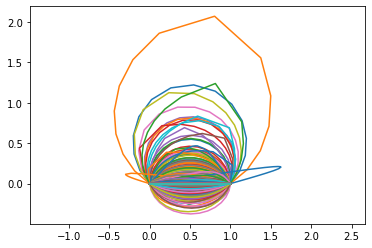

In [ ]:
# Pintamos algunas de esas poligonales
N_curvas2paint=400;
a=np.random.randint(0,len(X_numpy), N_curvas2paint)
b=np.sort(a)
#print(b)
X=X_numpy.real
Y=X_numpy.imag

for k in b:
  plt.plot(X[k,0:15],Y[k,0:15])

#plt.xlim([-1.5, 2.5])
#plt.ylim([-1, 3])
plt.axis('equal')
#plt.margins(x=-0.4,y=-0)

# Reorganizamos las curvas según su longitud


La longitud máxima es: 24.875373294937592


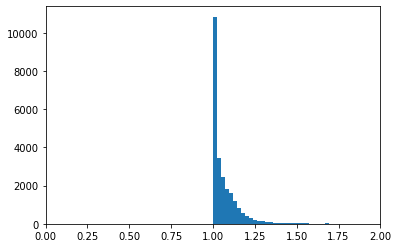

In [ ]:
longitudes=longitudes_pol(X_numpy)
longitudes2=np.array(longitudes)
longitudes3 =np.sort(longitudes2)
sort_indices=np.argsort(longitudes2)
X_numpy_sort=X_numpy[sort_indices,:]
plt.hist(longitudes3, bins=1000)
plt.xlim([0,2])
print('La longitud máxima es: '+ str(np.max(longitudes3)))
plt.show()

Según el histograma anterior un gran número de poligonales tienen longitudes entre 1 y 1.5. Por lo anterior no es conveniente incluir las poligonales con mayor longitud en el proceso de clusterización. En palabras coloquiales estariamos introduciendo "ruido".

Clusterizamos el 95% de las curvas. 


La longitud máxima es: 1.2862175959274942


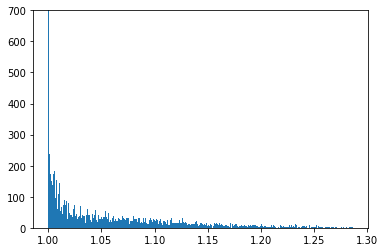

In [ ]:
a=0.95*len(X_numpy_sort)
indice_final=int(np.floor(a))
X_numpy_short=X_numpy_sort[range(indice_final),:]
# Hacemos de nuevo el histograma
longitudes4 =longitudes3[range(indice_final)]
plt.hist(longitudes4, bins=1000)
plt.ylim([0,700])
print('La longitud máxima es: '+ str(np.max(longitudes4)))
plt.show()
X_numpy=X_numpy_short

# Kmeans clusterization

In [ ]:
# Clusterización con kmeans
cluster_number = 60
X_numpy_r30_2=np.concatenate((X_numpy.real, X_numpy.imag),axis=1)
poligonal_number=800
np.random.seed(5)
indices=np.sort(np.random.choice(len(X_numpy),poligonal_number))
X_numpy_r30=X_numpy_r30_2[indices,:]
X_numpy=X_numpy[indices,:]

kmeans_model = KMeans(n_clusters = cluster_number)
kmeans_model.fit(X_numpy_r30)
centroides=kmeans_model.cluster_centers_
y_km=kmeans_model.fit_predict(X_numpy_r30)
labels = kmeans_model.labels_
kmeans_Silhuette_coefficient=metrics.silhouette_score(X_numpy_r30, labels, metric='euclidean')
# El anterior número da cuenta de la calidad de la clusterización
print(kmeans_Silhuette_coefficient)
labels2=kmeans_model.labels_

0.31487091657485666


## **Gráficas de codo para determinar un  K  adecuado**
Calculate the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, and choose the k for which WSS becomes first starts to diminish. In the plot of WSS-versus-k, this is visible as an elbow.
Within-Cluster-Sum of Squared Errors sounds a bit complex. Let’s break it down:


*   The Squared Error for each point is the square of the 
distance of the point from its representation i.e. its predicted cluster center.
* The WSS score is the sum of these Squared Errors for all the points.
* Any distance metric like the Euclidean Distance or the Manhattan Distance can be used.

In [ ]:
WSS = []
k_test = range(1,int(np.floor(len(X_numpy)/2)),int(np.floor(0.01*len(X_numpy))))

for k in k_test:
 kmeans_model_test = KMeans(n_clusters = k)
 kmeans_model_test.fit(X_numpy_r30)
 WSS.append(kmeans_model_test.inertia_)

plt.plot(k_test, WSS, 'bx-')
plt.xlabel("K")
plt.ylabel("WSS")
plt.title("Elbow graph")

## **Cálculo de la cantidad de curvas en cada cluster y reorganización de la clusterización**


In [ ]:
# algoritmo para reorganización de clusters
#labels_aux=labels

#for k in range(cluster_number-1):
 # for j in range(k+1,cluster_number):
  #  Numk=len(X_numpy[labels_aux==k])
   # Numj=len(X_numpy[labels_aux==j])
    #if Numk < Numj:
     # a=labels_aux==j
      #b=labels_aux==k
      #labels_aux[a]=k
      #labels_aux[b]=j
         
#print(labels_aux)
#X_numpy_r30=np.concatenate((X_numpy.real, X_numpy.imag),axis=1)
labels2=labels
# algoritmo para reorganización de clusters
labels_aux=labels
X_numpy2=X_numpy#[indices,:]
for k in range(cluster_number-1):
  for j in range(k+1,cluster_number):
    Numk=len(X_numpy2[labels_aux==k])
    Numj=len(X_numpy2[labels_aux==j])
    if Numk < Numj:
      a=labels_aux==j
      b=labels_aux==k
      labels_aux[a]=k
      labels_aux[b]=j
         
print(labels_aux)
X_numpy_r30=np.concatenate((X_numpy2.real, X_numpy2.imag),axis=1)


# Cluster Visualization. 
Use la función 

 paint_cluster(ncluster,clusters_pack)

 Para pintar un cluster, 
 Haga uso de la siguiente celda

## Pintar cluster

In [ ]:
from pylab import *
clusters_pack2 = [X_numpy2[labels_aux==i] for i in range(cluster_number)]
for f in range(cluster_number):
  figure(f)
  #ncluster=0 # Ponga el número del cluster que desea pintar
  paint_cluster(f,clusters_pack2)
show()

# Silhuette analisis
The Silhouette Coefficient is a measure of how well samples are clustered with samples that are similar to themselves. Clustering models with a high Silhouette Coefficient are said to be dense, where samples in the same cluster are similar to each other, and well separated, where samples in different clusters are not very similar to each other.

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.
Explicación:
Suponga que se ha realizado una clusterización sobre la base de datos.
El silhouette coeff. (sc_i) se calcula para cada poligonal. Así:
Suponga que tomamos la poligonal i-ésima y que está en el cluster #k (Ck)
Paso 1. Se halla el promedio de las distancias de la poligonal i, a todas las poligonales contenidas en el mismo cluster (cluster Ck). Este número se denota por (a_i), i= desde 1 hasta #poligonales.

Paso 2. Se halla la distancia promedio de la poligonal i a las poligonales del cluster Cj, con j diferente de k y luego se toma el mínimo de estas distancias promedios. Este número se denota (b_i)
Observaciones.
Se espera que b_i > a_i. Caso contrario la poligonalestá mal ubicada (Hay un cluster en el que encajaría mejor).
El silhuette coeff (sc_i), es: (b_i-a_i)/max(b_i,a_i).
El denominador max(b_i,a_i) es un factor de normalización.
El caso ideal sería: todos los cluster cumplen que la distancia entre dos de sus elementos es siempre cero y por tanto a_i=0 y la distancia entre elementos de clusters diferentes es siempre mayor que cero. En este caso sc_i=1.
El peor caso es cuando dos elementos iguales quedan en diferente cluster y por tanto b_i=0 pero la distancia entre elementos del mismo cluster no es cero así a_i>0. En este caso sc_i=-1.
Finalmente el silhuette coeff. (sc) de la clusterización es (b-a)/max(a,b) donde b es promedio de los b_i y a es el promedio de los a_i.


The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.



## Silhuette coefficient for each cluster


### Sihuette coefficients for kmeans

In [ ]:
# Arriba se calculó
#hc_Silhuette_coefficient=metrics.silhouette_score(X_numpy_r30, labels, metric='euclidean')
hc_Silhuette_coefficient=metrics.silhouette_score(X_numpy_r30, labels_aux, metric='euclidean')

# El anterior número da cuenta de la calidad de la clusterización
silhouette_avg=kmeans_Silhuette_coefficient

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_numpy_r30, labels_aux)
#print(sample_silhouette_values)
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(36, 100)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
ax1.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
space_cluster=75
ax1.set_ylim([0, len(X_numpy) + (cluster_number + 1) * space_cluster])
y_lower = space_cluster
color_option=['green', 'blue']
for i in range(cluster_number):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
      sample_silhouette_values[labels_aux == i]
    
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
  
    #color = cm.nipy_spectral(float(i) / cluster_number)  #Colormap type
    color=color_option[i % 2]
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    # Pintamos también el promedio de los coeficientes silhuette en cada cluster
    #ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    mpc=np.mean(sample_silhouette_values[labels_aux == i]) #mean per cluster
    #ax1.axvline(x=mpc, ymin=y_lower, ymax=y_lower+size_cluster_i, color="red", linestyle="--")
    ax1.plot([mpc, mpc],[y_lower, y_lower+size_cluster_i], \
             color="green", linestyle="--",linewidth=4)
   
   # Label the silhouette plots with their cluster numbers at the middle
    if size_cluster_i < 5:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 10:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 20:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 50:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else: 
        ax1.plot([mpc],[y_lower],'og') 
    elif size_cluster_i < 100:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
    elif size_cluster_i < 500:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=27)
    elif size_cluster_i < 1000:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=35)
    else:
      ax1.text(-0.2, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=40)

    # Compute the new y_lower for next plot
    y_lower = y_upper + space_cluster  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.",fontsize=36)
ax1.set_xlabel("The silhouette coefficient values",fontsize=36)
ax1.set_ylabel("Cluster label",fontsize=36)

    # The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.4,-0.3,-0.2,-0.1, 0, 0.1,0.2, 0.3,0.4,0.5, 0.6, 0.7,0.8,\
                    0.9, 1])
#plt.xticks(fontsize=16)
plt.xticks(fontsize=34)
plt.suptitle(("Silhouette analysis for kmeans clusterization "
               "with n_clusters = %d" % cluster_number),
              fontsize=28, fontweight='bold')

 #plt.show()
   


## Cálculo de coeficiente de compacidad
*mean intra-cluster distance (a)*
Para cada curva, calcularemos el coeficiente ai, el cual es el promedio de las distancias a todos los elementos del cluster que la contiene


### kmeans, mean intra-cluster distance (a) for each sample


In [ ]:
# Ingredientes
## labels  --> Contiene los indices de la clusterización, labels es un arreglo 
#              con la misma cantidad de elementos que poligonales. Cada entrada k de labels dice 
#              el indice del cluster al que pertenece la poligonal número k.
## X_numpy --> las poligonales en forma compleja
silhuette_a=[]
for i in range(len(X_numpy)):
  cpoli=X_numpy[i,:]   # tomo una curva
  label_cpoli=labels_aux[i]      # miro a que cluster pertenece
  aux=labels_aux==label_cpoli    # Guardo los indices de las curvas que están en el mismo cluster
  aux[i]=False               # quito el indice de cpoli
  cluster_cpoli=X_numpy[aux,:] # Tomo el cluster que contiene a la poligonal
  # Usamos la función que calcula distancias de una poligonal a una matriz de poligonales
  if len(cluster_cpoli)==0: # En este caso el cluster tiene una sola curva
    mean_distai=0
  else:
    [mean_distai,min_distai]=dist_pol(cpoli, cluster_cpoli)
  
  #almacenamos estos coeficientes
  silhuette_a.append(mean_distai)



#### Gráfico de comparación silhuette (a)

In [ ]:
#print(sample_silhouette_values)
sample_silhouette_values_a = np.asarray(silhuette_a)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(36, 100)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
ax1.set_xlim([-0.5, 1.5])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
space_cluster=75
ax1.set_ylim([0, len(X_numpy) + (cluster_number + 1) * space_cluster])
y_lower = space_cluster
color_option=['green', 'blue'] 
for i in range(cluster_number):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values_a = \
      sample_silhouette_values_a[labels_aux == i]
    
    ith_cluster_silhouette_values_a.sort()

    size_cluster_i = ith_cluster_silhouette_values_a.shape[0]
    y_upper = y_lower + size_cluster_i
    
  
    #color = cm.nipy_spectral(float(i) / cluster_number)  #Colormap type
    color=color_option[i % 2]
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values_a,
                      facecolor=color, edgecolor=color, alpha=0.7)
    # Pintamos también el promedio de los coeficientes silhuette en cada cluster
    #ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    mpc=np.mean(sample_silhouette_values_a[labels_aux == i]) #mean per cluster
    #ax1.axvline(x=mpc, ymin=y_lower, ymax=y_lower+size_cluster_i, color="red", linestyle="--")
    ax1.plot([mpc, mpc],[y_lower, y_lower+size_cluster_i], \
             color="green", linestyle="--",linewidth=4)


   # Label the silhouette plots with their cluster numbers at the middle
    if size_cluster_i < 5:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 10:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 20:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 50:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else: 
        ax1.plot([mpc],[y_lower],'og') 
    elif size_cluster_i < 100:
      ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
    elif size_cluster_i < 500:
      ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=27)
    elif size_cluster_i < 1000:
      ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=35)
    else:
      ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=40)

    # Compute the new y_lower for next plot
    y_lower = y_upper + space_cluster  # 10 for the 0 samples

ax1.set_title("The silhouette intra mean-coefficient plot for the various clusters.",fontsize=36)
ax1.set_xlabel("The silhouette intra-mean coefficient values",fontsize=36)
ax1.set_ylabel("Cluster label",fontsize=36)

silhouette_avg_a=np.mean(sample_silhouette_values_a)
    # The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg_a, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.4,-0.2, 0, 0.2,0.4, 0.6,0.8,1, 1.2, 1.4])
                   
#plt.xticks(fontsize=16)
plt.xticks(fontsize=34)
plt.suptitle(("a-Silhouette analysis for KMeans clusterization "
               "with n_clusters = %d" % cluster_number),
              fontsize=28, fontweight='bold')

## Cálculo del coeficiente de separación de clusters
*mean nearest-cluster distance (b)* 
Para cada poligonal buscaremos la distancia de esa poligonal a cada una de las curvas de los otros cluster (en los que no están contenidas). Entre mas grande sea este valos mejor es la clusterización.

### kmeans, mean nearest-cluster distance (b) for each sample

In [ ]:
# Ingredientes
## labels  --> Contiene los indices de la clusterización, labels es un arreglo 
#              con la misma cantidad de elementos que poligonales. Cada entrada k de labels dice 
#              el indice del cluster al que pertenece la poligonal número k.
## X_numpy --> las poligonales en forma compleja

# Parte 1, agrupacón de clusters
clusters_pack = [X_numpy[labels_aux==i] for i in range(cluster_number)]

silhuette_b=[]
for i in range(len(X_numpy)):
  cpoli=X_numpy[i,:]   # tomo una curva
  label_cpoli=labels_aux[i]      # miro a que cluster pertenece
  silhuette_aux_b=[]
  for k in range(cluster_number):
    if k!=label_cpoli:
      clusterk=clusters_pack[k]
      (mean_distk,min_distk)=dist_pol(cpoli, clusterk)
      silhuette_aux_b.append(mean_distk)

  
  silhuette_b.append(min(silhuette_aux_b))



#### Gráfico de comparación silhueete (b)

In [ ]:
#print(sample_silhouette_values)
sample_silhouette_values_b = np.asarray(silhuette_b)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(36, 100)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
ax1.set_xlim([-0.5, 1.5])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
space_cluster=75
ax1.set_ylim([0, len(X_numpy) + (cluster_number + 1) * space_cluster])
y_lower = space_cluster
color_option=['green', 'blue'] 
for i in range(cluster_number):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values_b = \
      sample_silhouette_values_b[labels_aux == i]
    
    ith_cluster_silhouette_values_b.sort()

    size_cluster_i = ith_cluster_silhouette_values_b.shape[0]
    y_upper = y_lower + size_cluster_i
    
  
    #color = cm.nipy_spectral(float(i) / cluster_number)  #Colormap type
    color=color_option[i % 2]
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values_b,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Pintamos también el promedio de los coeficientes silhuette en cada cluster
    #ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    mpc=np.mean(sample_silhouette_values_b[labels_aux == i]) #mean per cluster
    #ax1.axvline(x=mpc, ymin=y_lower, ymax=y_lower+size_cluster_i, color="red", linestyle="--")
    ax1.plot([mpc, mpc],[y_lower, y_lower+size_cluster_i], \
             color="green", linestyle="--",linewidth=4)


    # Label the silhouette plots with their cluster numbers at the middle
    if size_cluster_i < 5:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 10:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 20:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else:
        ax1.plot([mpc],[y_lower],'og')
    elif size_cluster_i < 50:
      if i % 2 == 1: # para escribir solo los impares
        ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
        ax1.plot([mpc],[y_lower],'og')
      else: 
        ax1.plot([mpc],[y_lower],'og') 
    elif size_cluster_i < 100:
      ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=20)
    elif size_cluster_i < 500:
      ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=27)
    elif size_cluster_i < 1000:
      ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=35)
    else:
      ax1.text(-0.4, y_lower + 0.5 * size_cluster_i, 'C'+str(i)+' with '+str(size_cluster_i),size=40)

    # Compute the new y_lower for next plot
    y_lower = y_upper + space_cluster  # 10 for the 0 samples

ax1.set_title("The silhouette mean - nearest -clusterdistance plot for the various clusters.",fontsize=36)
ax1.set_xlabel("The silhouette mean - nearest -clusterdistance values",fontsize=36)
ax1.set_ylabel("Cluster label",fontsize=36)
silhouette_avg_b=np.mean(sample_silhouette_values_b)
    # The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg_b, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
#ax1.set_xticks([ 0, 0.5,1, 1.5,2,2.5, 3, 3.5,4,4.5, 5])
#ax1.set_xticks([ 0, 0.2,0.4, 0.6,0.8,1, 1.2, 1.4,1.6,1.8,2,2.2,2.4,2.6,2.8,3])
ax1.set_xticks([ -0.4,-0.2,0, 0.2,0.4, 0.6,0.8,1, 1.2, 1.4])

#plt.xticks(fontsize=16)
plt.xticks(fontsize=34)
plt.suptitle(("b-Silhouette analysis for KMeans clusterization "
               "with n_clusters = %d" % cluster_number),
              fontsize=28, fontweight='bold')

# Graficos de clusters
Escogemos 20 cluster aleatorios y los desplegamos